# Topic Modeling Discovery

In [1]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle 

# nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# spacy
import spacy

# corex
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

from preprocessing_funcs import clean_tweet, get_hashtags, get_emojis

In [2]:
with open('../data_files/processed_tweets.pickle', 'rb') as read_file:
    tweets = pickle.load(read_file)

In [3]:
tweets.head()

,text,processed
0,#IslamKills Are you trying to say that there w...,islam kill try say terrorist attack europe ref...
1,"Clinton: Trump should’ve apologized more, atta...",clinton trump apologize attack little
2,RT @ltapoll: Who was/is the best president of ...,well president past retweet
3,RT @jww372: I don't have to guess your religio...,guess religion christmas aftermath
4,RT @Shareblue: Pence and his lawyers decided w...,pence lawyer decide official email public can see


In [4]:
tweets.tail()

,text,processed
203477,"RT @AndreaChalupa: In intel circles, the story...",intel circle story go fsb film trump orgy russ...
203478,RT @KansasCityDNews: Tonganoxie police: Middle...,tonganoxie police middle school girl sexually ...
203479,RT @signsinyork: Getting the right #company lo...,get right company logo business get message ac...
203480,The Latest: Obama affirms continuity of ties w...,late obama affirm continuity tie canada
203481,RT @futureguru100: U cant just Upload a CD onl...,u can not upload cd online product work u get ...


In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203482 entries, 0 to 203481
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       203482 non-null  object
 1   processed  203482 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


In [6]:
tweets.head()

,text,processed
0,#IslamKills Are you trying to say that there w...,islam kill try say terrorist attack europe ref...
1,"Clinton: Trump should’ve apologized more, atta...",clinton trump apologize attack little
2,RT @ltapoll: Who was/is the best president of ...,well president past retweet
3,RT @jww372: I don't have to guess your religio...,guess religion christmas aftermath
4,RT @Shareblue: Pence and his lawyers decided w...,pence lawyer decide official email public can see


In [7]:
proc_tweets = tweets.processed

## KMeans

In [8]:
%%time

tfidfconvert = TfidfVectorizer(use_idf=True, smooth_idf=True, max_features=60000, stop_words='english')
tweets_transformed = tfidfconvert.fit_transform(proc_tweets)

CPU times: user 1.79 s, sys: 46.4 ms, total: 1.84 s
Wall time: 1.84 s


In [9]:
%%time
inertias = []

for k_ in np.arange(1, 21):
    km = KMeans(n_clusters=k_)
    km.fit(tweets_transformed)
    inertias.append(km.inertia_)

CPU times: user 1h 1min 47s, sys: 1min 42s, total: 1h 3min 30s
Wall time: 8min 1s


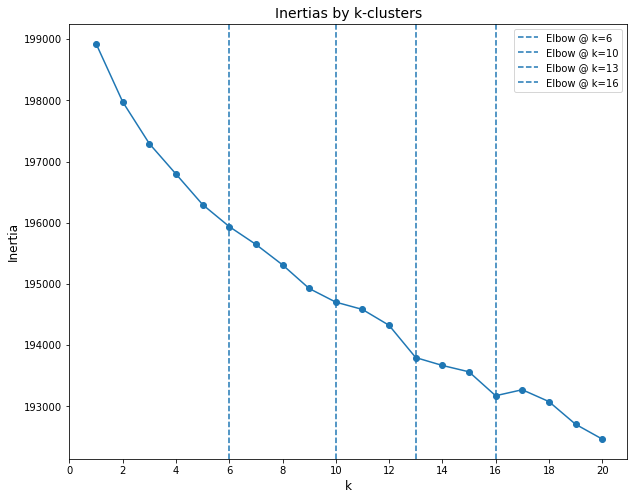

In [11]:
%matplotlib inline
plt.figure(figsize=(10, 8))
plt.plot(np.arange(1, 21), inertias, marker='o')
plt.axvline(x=6, ls='--', label='Elbow @ k=6')
plt.axvline(x=10, ls='--', label='Elbow @ k=10')
plt.axvline(x=13, ls='--', label='Elbow @ k=13')
plt.axvline(x=16, ls='--', label='Elbow @ k=16')
plt.xticks(np.arange(0, 22, step=2))
plt.title('Inertias by k-clusters', fontsize=14)
plt.ylabel("Inertia", fontsize=12)
plt.xlabel('k', fontsize=12)
plt.legend();

## Topic Modeling

In [12]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

### LSA

Will start with 10 topics - the most pronounced first elbow from above.

In [13]:
vectorizer = TfidfVectorizer(use_idf=True, 
                             smooth_idf=True,
                             stop_words='english')

svd_model = TruncatedSVD(n_components=10, 
                         algorithm='randomized',
                         n_iter=100,
                         random_state=42)

# pipeline of tf-idf + SVD, fit and applied to docs: 

svd_transformer = Pipeline([('tfidf', vectorizer),
                           ('svd', svd_model)])

svd_matrix = svd_transformer.fit_transform(proc_tweets)

In [14]:
terms = vectorizer.get_feature_names()

display_topics(svd_model, terms, 10)


Topic  0
trump, hillary, donald, clinton, real, president, america, say, make, obama

Topic  1
hillary, clinton, twitter, conservative, patriot, network, email, journalist, obama, thing

Topic  2
twitter, conservative, patriot, network, journalist, christian, america, wake, make, cruz

Topic  3
make, america, people, great, like, know, say, obama, good, love

Topic  4
make, america, great, hillary, real, donald, phrase, hate, clinton, wake

Topic  5
president, obama, trump, run, politic, say, news, america, day, elect

Topic  6
debate, topic, reject, politic, alternative, say, gop, night, make, trump

Topic  7
say, obama, politic, news, clinton, america, black, make, donald, islam

Topic  8
know, right, obama, real, donald, patriot, need, journalist, network, want

Topic  9
say, know, trump, right, like, make, thing, twitter, love, good


Try again with CountVectorizer

In [15]:
vectorizer = CountVectorizer(binary=True, 
                             stop_words='english')

svd_model = TruncatedSVD(n_components=10, 
                         algorithm='randomized',
                         n_iter=100,
                         random_state=42)

# pipeline of tf-idf + SVD, fit and applied to docs: 

svd_transformer = Pipeline([('cv', vectorizer),
                           ('svd', svd_model)])

svd_matrix = svd_transformer.fit_transform(proc_tweets)

In [16]:
terms = vectorizer.get_feature_names()

display_topics(svd_model, terms, 10)


Topic  0
trump, donald, hillary, clinton, real, say, president, obama, america, politic

Topic  1
hillary, clinton, obama, email, campaign, twitter, conservative, fbi, say, debate

Topic  2
twitter, conservative, patriot, journalist, network, obama, christian, america, wake, make

Topic  3
obama, say, make, people, president, like, news, black, know, want

Topic  4
donald, real, hillary, make, america, people, great, like, thing, know

Topic  5
make, people, say, america, like, great, black, know, want, thing

Topic  6
clinton, donald, make, real, america, politic, great, news, new, email

Topic  7
say, people, donald, real, like, black, know, thing, live, twitter

Topic  8
people, like, black, live, clinton, twitter, know, white, matt, think

Topic  9
patriot, journalist, network, black, live, people, matt, cruz, american, crow


Feels like there's a bit more variety in the CountVectorizer version. But there's not a lot of variety between the topics anyway. Maybe 10 is too many?

### NMF

In [17]:
vectorizer = CountVectorizer(binary=True, 
                             stop_words='english')

nmf_model = NMF(n_components=10)

# pipeline of tf-idf + SVD, fit and applied to docs: 

nfm_transformer = Pipeline([('cv', vectorizer),
                           ('nmf', nmf_model)])

nmf_matrix = nfm_transformer.fit_transform(proc_tweets)

In [18]:
terms = vectorizer.get_feature_names()

display_topics(nmf_model, terms, 10)


Topic  0
trump, president, politic, maga, donald, supporter, news, medium, poll, debate

Topic  1
hillary, crook, thing, trust, lie, maga, prison, debate, want, benghazi

Topic  2
twitter, conservative, christian, party, tea, gop, maga, america, wake, tgdn

Topic  3
obama, president, news, barack, michelle, isis, politic, world, administration, house

Topic  4
donald, real, trump, america, need, potus, mike, maga, thank, time

Topic  5
make, america, great, hate, wake, phrase, president, let, good, day

Topic  6
clinton, politic, email, campaign, foundation, fbi, new, news, debate, poll

Topic  7
say, news, good, election, know, want, woman, politic, thing, time

Topic  8
people, like, black, know, live, thing, want, think, look, white

Topic  9
patriot, journalist, network, cruz, crow, america, wake, ted, american, nra


Pretty similar to LSA

### Corex

[lecture example notebook](https://github.com/scrapfishies/onl20_ds4/blob/master/curriculum/project-04/fancy-nlp/corex/CorEx.ipynb)

In [19]:
vectorizer = CountVectorizer(token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True,
                             stop_words='english')

doc_word = vectorizer.fit_transform(proc_tweets)
words = list(np.asarray(vectorizer.get_feature_names()))

In [20]:
topic_model = ct.Corex(n_hidden=10, 
                       words=words,
                       max_iter=200, 
                       seed=42)


topic_model.fit(doc_word, words=words, docs=proc_tweets)

In [21]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n, topic in enumerate(topics):
    topic_words, _ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: conservative, twitter, network, journalist, patriot, christian, merkel, muss, tea, islam
1: news, police, post, black, midnight, white, campaign, fbi, report, state
2: trump, donald, real, politic, president, maga, poll, supporter, rally, pence
3: oscar, play, color, ft, oscars, feat, gt, music, ben, oscarssowhite
4: hillary, clinton, email, crook, foundation, wikileaks, politician, gift, benghazi, bernie
5: cruz, ted, crow, isis, john, law, ice, saudi, op, target
6: guide, thanksgiving, survival, click, water, promotion, mixtape, soundcloud, west, fall
7: wear, car, local, boy, bowl, driver, man, room, truck, park
8: obama, american, illegal, americans, michelle, obamacare, barack, african, enlist, climate
9: know, right, people, truth, lie, think, liberal, really, want, need


These topics look more promising - much more diverse

In [24]:
# Let's check out topic : graphics
topic_model.get_top_docs(topic=4, n_docs=10)

[('cheryl mill hillary aid get immunity hillary clinton email scandal sicken democratic party',
  0.0),
 ('hillary clinton sphincter transplant word sphincter reject anncoulter hillaryfordumm',
  0.0),
 ('new trump ad trump campaign respond hillary basket deplorables comment maga hillarys health',
  0.0),
 ('statement attempt coverup clinton email state department wikileaks hillarys email crook',
  0.0),
 ('percent crook hillary clinton foundation budget actually go charity maga',
  0.0),
 ('excite welcome loyolahounds hall fame class back loyolamaryland weekend thrill honor distinguis',
  0.0),
 ('bill clinton rape cover ou speech via campusreform never hillary clintoncrimes',
  0.0),
 ('break hillarys huma abedin miss clinton body count via youtube fbireopenscase maga c',
  0.0),
 ('racysicilian hillary clinton afterbill rape womenu psychologically rapedthem defendbill stop deflect',
  0.0),
 ('softnumnums mare secviar jimasher hillary clinton one obsess obama bear',
  0.0)]

Yikes

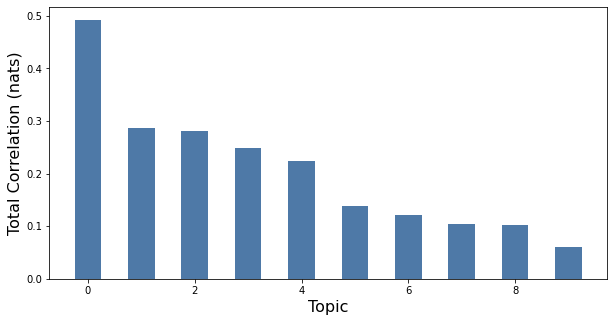

In [25]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

Testing some anchors based on the topic results

In [26]:
topics = [['donald', 'trump', 'maga'],                                             # trump stuff
          ['hillary', 'clinton'],                                                  # hillary stuff
          ['merkel', 'muss', 'die', 'ist', 'ich', 'das'],                          # german stuff
          ['color', 'blm', 'black', 'matt', 'oscar', 'racism', 'blacktwitter'],    # BLM/race stuff
          ['police', 'officer', 'shoot'],                                          # police stuff
          ['obama', 'barack'],                                                     # obama stuff
          ['isis', 'muslim', 'islam']                                              # isis/islam stuff
         ]

len(topics)

7

Will plot out 7 anchors and let CorEx decide the rest

In [27]:
topic_model = ct.Corex(n_hidden=10, 
                       words=words,
                       max_iter=200, 
                       seed=42)

topic_model.fit(doc_word, words=words, docs=proc_tweets, 
                anchors=topics, anchor_strength=5)

In [28]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: trump, donald, maga, real, president, supporter, politic, train, poll, rally
1: hillary, clinton, email, campaign, crook, foundation, fbi, trust, wikileaks, benghazi
2: die, merkel, muss, ist, das, ich, sie, es, mit, den
3: black, matt, color, racism, oscar, blm, blacktwitter, live, white, oscars
4: police, shoot, officer, san, cop, suspect, nodapl, pipeline, arrest, dakota
5: obama, journalist, network, patriot, barack, conservative, twitter, christian, tea, michelle
6: islam, isis, muslim, kill, refugee, brussels, muslims, terrorist, prayforbrussels, islamic
7: cruz, ted, guide, thanksgiving, survival, crow, censorship, cyber, gt, click
8: news, medium, election, state, report, gop, post, cnn, new, russia
9: midnight, christmas, phrase, play, dinner, aftermath, ruin, america, reallifemagicspells, ft


In [30]:
# Let's check out topic : graphics
topic_model.get_top_docs(topic=1, n_docs=10)

[('lie pander cover hillary dw promote clinton foundation red nation rise',
  0.0),
 ('clinton suggest russia work elect trump', 0.0),
 ('vikkideiter cnn clinton george soros headquarter never ever tell truth',
  0.0),
 ('hillary proclaim jihadists radical face palm islam kill stop islam', 0.0),
 ('story hillary little girl', 0.0),
 ('trump hillary question debate video daily caller', 0.0),
 ('right sid blumenthal random clinton supporter', 0.0),
 ('inform bill clinton rape woman hillary fund isis please oh great one inform robert byr',
  0.0),
 ('florida poll clinton trump virtually tie politic', 0.0),
 ('trumpsarmy urrrg hillary dirty sneaky thing', 0.0)]

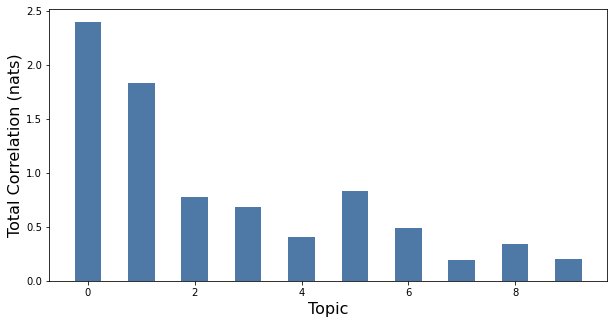

In [31]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

In [33]:
topic_model.tc

8.131715395509769

CorEx seems the most promising and I like the anchors. I'll wrap up this notebook as model discovery and start another to focus solely on CorEx.